In [271]:
!{sys.executable} -m pip install pandas 

  Using cached pandas-1.5.0-cp310-cp310-win_amd64.whl (10.4 MB)
  Using cached pytz-2022.4-py2.py3-none-any.whl (500 kB)


In [2]:
#Imports 
import pip
import glob, os
from sklearn import svm 
import scipy.io
import numpy as np
from HelperFunctions_ import write_dataset_to_file, split_dataset_paths
import sys 
from spectral import *

import tables as tab
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.semi_supervised import SelfTrainingClassifier
import pandas as pd
from sklearn import datasets
import copy
import spectral


In [3]:
#Finding path names 
Mjosa_data = split_dataset_paths("../Datasets/2022_07_11_Mjosa/2022_07_11_Mjosa/", ["he5", "csv", "jpg"])
Andebu_data = split_dataset_paths("../Datasets/2021_07_21_Andebu/2021_07_21_Andebu/", ["he5", "csv", "jpg"])
Telemark_data = split_dataset_paths("../Datasets/2020_06_23_Telemarkskanalen/2020_06_23_Telemarkskanalen/", ["he5", "csv", "jpg"])


In [4]:
#Amount of dataset should be handled
N_datasets = 4

#Open files 
open_files_array = []
for i in range(N_datasets):
    file = tab.open_file(Mjosa_data["he5"][i])
    open_files_array.append(file.get_node("/HDFEOS/SWATHS/PRS_L1_HCO/")['Data Fields']['VNIR_Cube'][:,5:,:])

#Load the labels 
load_labels_array = []
for i in range(N_datasets):
    file = Mjosa_data["csv"][i]
    load_labels_array.append(np.loadtxt(file, dtype=np.ubyte))

In [5]:
#Indian pines dataset laod 
indian_pines_gt = scipy.io.loadmat("../HyperSpectralData/Hyperspectral Remote Sensing Scenes/Indian_pines_gt.mat")
indian_pines = scipy.io.loadmat("../HyperSpectralData/Hyperspectral Remote Sensing Scenes/Indian_pines.mat")

In [6]:
#print(indian_pines_gt["indian_pines_gt"])
#print(len(indian_pines_corrected["indian_pines_corrected"][0]))

In [105]:
data1 = open_files_array[0]
labels1 = load_labels_array[0]

#data = indian_pines["indian_pines"]
#labels = indian_pines_gt["indian_pines_gt"]

print(data[0])

[[ 315  431 2280 ... 1829 1678 2027]
 [ 332  425 1661 ... 1392 1324 1674]
 [ 325  436 2552 ... 1974 2062 2075]
 ...
 [ 327  387 4691 ... 6762 6095 6462]
 [ 327  382 6225 ... 9399 7239 7261]
 [ 323  366 5418 ... 7678 7266 7890]]


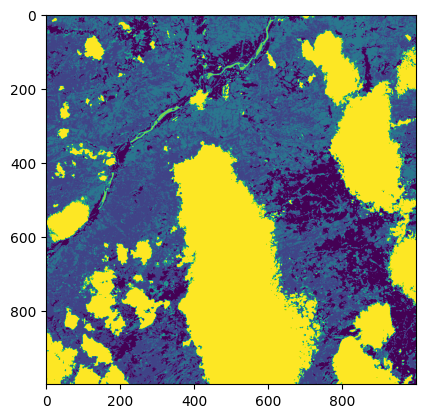

In [8]:
#view = imshow(data, (1000,61,1000))
# plot the labels
plt.imshow(labels)

In [29]:
sub_data, sub_labels = subFrame(data, labels, 400, 600, 0, 200)
#new_sub_label = OneClass(labels, class_values=[0,1])

In [96]:

# 1) Spruce, 2) Pine , 3) Decidous (leaf), 4) Water, 5) Clouds, and 0) other
name_labels = ["Other", "Spruce", "Pine", "Decidous", "Water", "Clouds"]

nLabels = namesOnLabels(sub_labels,name_labels)

In [97]:
def preprocessing_data(data,labels): 
    # prepare data
    X = data.transpose(0,2,1).reshape((-1,61))
    #X = data.transpose(0,2,1).reshape((-1,20))
    #X = data.reshape(-1, 61)
    y = labels.flatten()

    X = preprocessing.scale(X, axis=0)                    # Normalization
    #X = preprocessing.normalize(X, axis=0) 
    return X,y

"""
print(data.shape[1])
X_sub,y_sub = preprocessing_data(sub_data, sub_label)
X,y = preprocessing_data(data, labels)
print(X.shape, y.shape)
"""
X = sub_data.transpose(0,2,1).reshape((-1,61))
y = nLabels.flatten()

scaler = preprocessing.MinMaxScaler()

scaler.fit(X)
X = scaler.transform(X)




In [98]:

"""
# prepare data
X = data.transpose(0,2,1).reshape((-1,61))
y = labels.flatten()

X = preprocessing.scale(X, axis=0)                    # Normalization
#X = preprocessing.normalize(X, axis=0)             # Standardization
print(X.shape, y.shape)
"""
"""
X_array, y_array = [],[]

X,y = preprocesing_data(data=data, labels=labels)
    
X_array.append(X)
y_array.append(y)

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X_array, y_array, test_size=0.999, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

"""
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.9, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)




(4000, 61) (36000, 61) (4000,) (36000,)


In [91]:
class_weights = {0: 5, 1: 5, 2: 5, 3: 20 , 4:0.1, 5:0.1}
#class_weights = {0:1, 1:1}

In [99]:
#Linear SVM 
# Generate SVM from training data
# 1) Spruce, 2) Pine , 3) Decidous (leaf), 4) Water, 5) Clouds, and 0) other
svma = SVC(kernel = "rbf", max_iter=1e5, tol=1e-5, class_weight=class_weights)
svmb = SVC(kernel = "linear", max_iter=1e5, tol=1e-5)

#svma.fit(X_train,y_train)
#svmb.fit(X_train, y_train)

#print(svma.support_)
#print(svmb.support_)

"""
svma = SVC(
    C = 10,
    kernel = "rbf", 
    degree = 3,
    gamma = "scale", 
    coef0 = 0.0, 
    probability = True, 
    tol = 1e-3, 
    cache_size = 400,
    class_weight = None, 
    verbose = True, 
    max_iter = 1e5, 
    decision_function_shape = "ovr",
    break_ties = True, 
    random_state = 1
)

svma.fit(X_train, y_train)
print("support vectors:", len(svma.support_))
print(svma.classes_)
"""



'\nsvma = SVC(\n    C = 10,\n    kernel = "rbf", \n    degree = 3,\n    gamma = "scale", \n    coef0 = 0.0, \n    probability = True, \n    tol = 1e-3, \n    cache_size = 400,\n    class_weight = None, \n    verbose = True, \n    max_iter = 1e5, \n    decision_function_shape = "ovr",\n    break_ties = True, \n    random_state = 1\n)\n\nsvma.fit(X_train, y_train)\nprint("support vectors:", len(svma.support_))\nprint(svma.classes_)\n'

In [100]:
#Decision Tree 
#Make the different models. 
from sklearn.linear_model import LogisticRegression

model_list = [("svma", svma), ("svmb", svmb)]

def combineModels(models): 
    from sklearn.ensemble import StackingClassifier
    stack_models = StackingClassifier(estimators=models, final_estimator=SVC(kernel="rbf"))
    return stack_models

stack_models = combineModels(model_list)

stack_models.fit(X_train,y_train)
print(stack_models)

c:\Users\jonas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\jonas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\jonas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\jonas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.wa

StackingClassifier(estimators=[('svma',
                                SVC(class_weight={0: 5, 1: 5, 2: 5, 3: 20,
                                                  4: 0.1, 5: 0.1},
                                    max_iter=100000.0, tol=1e-05)),
                               ('svmb',
                                SVC(kernel='linear', max_iter=100000.0,
                                    tol=1e-05))],
                   final_estimator=SVC())


In [101]:
stack_models.score(X_test, y_test)

0.6244722222222222

In [36]:
# calculate overall accuracy on Training data
(svma.predict(X_train)==y_train).sum()/len(y_train)

NotFittedError: This SVC instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
# Accuracy on test data
(svma.predict(X_test)==y_test).sum()/len(y_test)

0.6857222222222222

TypeError: Image data of dtype <U8 cannot be converted to float

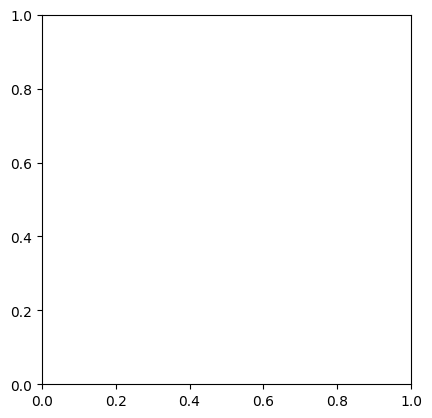

In [103]:
def confusionMatrix(data, labels):
    Xout = stack_models.predict(X)

    plt.imshow(Xout.reshape((200,200)))

    cm = confusion_matrix(labels, data)

    plt.imshow(cm, vmax=1, vmin=0) 
    plt.ylabel('True')
    plt.xlabel('prediction')
    plt.colorbar()

X_out = stack_models.predict(X)
X_out.reshape((200,200))

confusionMatrix(X_out, nLabels.flatten())

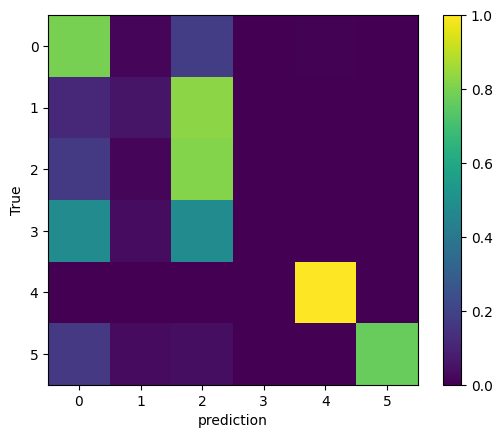

In [40]:
Xout = stack_models.predict(X)

plt.imshow(Xout.reshape((200,200)))

cm = confusion_matrix(sub_labels.flatten(), Xout, normalize='true')

plt.imshow(cm, vmax=1, vmin=0) 
plt.ylabel('True')
plt.xlabel('prediction')
plt.colorbar()

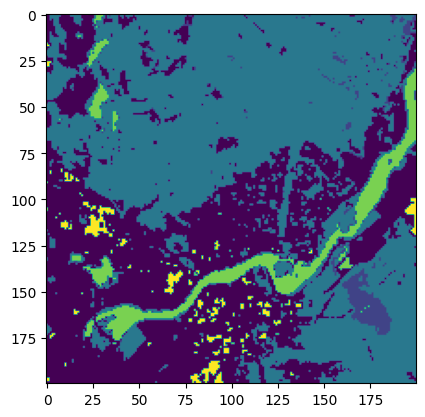

In [41]:
plt.imshow(Xout.reshape((200,200)))

In [ ]:
print(stack_models.score(X, y))


0.616353


AttributeError: 'StackingClassifier' object has no attribute 'support_'